# Preamble

In [125]:
# Standard libraries
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams['figure.dpi'] = 300
import random
import csv
import pandas as pd
import h5py
import gc  # garbage collection
# Scikit learn libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# PyTorch libraries
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
# from torchvision.transforms import ToTensor, Normalize 
# Get dirs
import os
cwd = os.getcwd()# "Code" folder
master_dir = os.path.abspath(os.path.join(cwd, ".."))
## ONNX
# import onnx
# import onnxruntime

When using __Google Colab__, run the following cell

In [126]:
# from google.colab import drive
# drive.mount('/content/drive')
# code_dir = "/content/drive/MyDrive/KUL/MAI thesis/Code"
# master_dir = os.path.join(code_dir, "..")
# os.chdir(code_dir)
# print(os.getcwd())

In [127]:
# Load own scripts:
%load_ext autoreload
%autoreload 2
import physics
import data
import nnc2p

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Point towards the folder where we store the EOS tables (__Note:__ they are not in the Github as these are very large files. Look inside the notebook to see which EOS tables we use, they can be downloaded from the stellarcollapse webpage.)

In [128]:
eos_tables_dir = os.path.join("D:/Coding/Datasets/eos_tables")  # offline
# eos_tables_dir = os.path.join(master_dir, "Data")  # in Google Colab
print(f"Going to look for EOS tables at {eos_tables_dir}")

Going to look for EOS tables at D:/Coding/Datasets/eos_tables


For the training, check if GPU is available (**Google Colab**):

In [129]:
if torch.cuda.is_available(): 
    DEVICE = "cuda:0" 
    torch.set_default_device('cuda')
else: 
    DEVICE = "cpu" 
print(f"Device for training: {DEVICE}")

Device for training: cpu


# Introduction

Here, we try to find a way to generalize the NN approach from the first semester to the situation of tabular EOS. 

*Note*: We use HDF5 files, but you have to close them manually. Forgot to close one? Check if there is still an open HDF5 file with garbage collect in the memory, and close it:

In [130]:
# Browse through objects
for obj in gc.get_objects():
    # see if is an HDF5 file
    if isinstance(obj, h5py.File):
        print(obj)
        try:
            obj.close()
            del obj
        except:
            pass
gc.collect()

D:\Anaconda\lib\site-packages\torch\distributed\distributed_c10d.py:181: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


<Closed HDF5 file>
<Closed HDF5 file>


3419

# Exploring EOS tables

Specify the EOS. Other downloaded EOS tables: `"GShen_NL3EOS_rho280_temp180_ye52_version_1.1_20120817.h5"`, `"SLy4_0000_rho391_temp163_ye66.h5"`

In [154]:
# Then specify which we are going to use here
eos_table_filename = "SLy4_0000_rho391_temp163_ye66.h5"

Read in the SLy4 EOS table using our py script: (make sure to close HDF5 files!)

In [155]:
# Open EOS table
eos_table = physics.read_eos_table(os.path.join(eos_tables_dir, eos_table_filename))
# Read in the most important variables and convert them to np arrays
dim_ye, dim_temp, dim_rho = eos_table["pointsye"][()][0], eos_table["pointstemp"][()][0], eos_table["pointsrho"][()][0]
logrho       = eos_table["logrho"][()]
logtemp      = eos_table["logtemp"][()]
ye           = eos_table["ye"][()]
logpress     = eos_table["logpress"][()]
logenergy    = eos_table["logenergy"][()]
energy_shift = eos_table["energy_shift"][()][0]
cs2          = eos_table["cs2"][()]
print(f"This EOS table has dimensions (ye, T, rho): {dim_ye} x {dim_temp} x {dim_rho}")
# Small test to see the output of the EOS table
test_ye      = eos_table["ye"][()][0]
test_temp    = eos_table["logtemp"][()][0]
test_rho     = eos_table["logrho"][()][0]
# Get an example output
test_press, test_eps = eos_table["logpress"][()][0, 0, 0], eos_table["logenergy"][()][0, 0, 0]
print(f"Example: ({test_rho}, {test_temp}, {test_ye}) we have (log eps, log p, cs2): ({test_eps}, {test_press}, {cs2[0, 0, 0]}).")
eos_table.close()

This EOS table has dimensions (ye, T, rho): 66 x 163 x 391
Example: (3.0239960056064277, -3.0, 0.005) we have (log eps, log p, cs2): (19.2791052025363, 17.99956975587081, 1575737840983096.0).


__Extra:__ Save only most important variables for epsilon to energy procedure.

In [156]:
# with h5py.File(os.path.join(eos_tables_dir, "energy_table.h5"), 'w') as f:
#     # Save the features and labels data
#     dataset = f.create_dataset("logrho", data=logrho)
#     dataset = f.create_dataset("logtemp", data=logtemp)
#     dataset = f.create_dataset("ye", data=ye)
#     dataset = f.create_dataset("logenergy", data=logenergy)
#     dataset = f.create_dataset("energy_shift", data=energy_shift)

In [133]:
# np.savetxt("energy_shift.txt", [energy_shift])

What is the input range of this table?

In [134]:
print(f"logrho    range:({min(logrho)}, {max(logrho)})")
print(f"logtemp range:({min(logtemp)}, {max(logtemp)})")
print(f"ye             range:({min(ye)}, {max(ye)})")

logrho    range:(3.0239960056064277, 16.023996005606428)
logtemp range:(-3.0, 2.4000000000000004)
ye             range:(0.005, 0.655)


See what is inside this EOS table

In [135]:
# # Iterate over keys and save them to list for simplified viewing
# keys = []
# for key in eos_table:
#     keys.append(key)
# print(keys)
# print(len(keys))

## Output
# ['Abar', 'Albar', 'MERGE-space.in', 'MERGE-src.tar.gz', 'MERGE-tables.in', 'MERGE-transition.in', 'SNA-skyrme.in', 'SNA-space.in', 'SNA-src.tar.gz', 'Xa', 'Xh', 'Xl', 'Xn', 'Xp', 'Zbar', 'Zlbar', 'cs2', 'dedt', 'dpderho', 'dpdrhoe', 'energy_shift', 'entropy', 'gamma', 'have_rel_cs2', 'logenergy', 'logpress', 'logrho', 'logtemp', 'meffn', 'meffp', 'mu_e', 'mu_n', 'mu_p', 'muhat', 'munu', 'pointsrho', 'pointstemp', 'pointsye', 'r', 'u', 'ye']

The universal neural network architecture that we will rely on for the tasks defined below:

In [136]:
class Net(nn.Module):
    """
    Implements a simple feedforward neural network.
    """
    def __init__(self, nb_of_inputs: int = 3, nb_of_outputs: int = 1, h: list = [600, 200], reg: bool = False, 
                 activation_function = torch.nn.Sigmoid, output_bias=True) -> None:
        """
        Initialize the neural network class.
        """
        # Call the super constructor first
        super(Net, self).__init__()
        
        # For convenience, save the sizes of the hidden layers as fields as well
        self.h = h
        # Add visible layers as well: input is 3D and output is 1D
        self.h_augmented = [nb_of_inputs] + h + [nb_of_outputs]

        # Add field to specify whether or not we do regularization
        self.regularization = reg

        # Define the layers:
        for i in range(len(self.h_augmented)-1):
            if i == len(self.h_augmented)-2:
                setattr(self, f"linear{i+1}", nn.Linear(self.h_augmented[i], self.h_augmented[i+1], bias=output_bias))
            else:
                setattr(self, f"linear{i+1}", nn.Linear(self.h_augmented[i], self.h_augmented[i+1]))
                setattr(self, f"activation{i+1}", activation_function())

    def forward(self, x):
        """
        Computes a forward step given the input x.
        :param x: Input for the neural network.
        :return: x: Output neural network
        """
        
        for i, module in enumerate(self.modules()):
            # The first module is the whole NNC2P object, continue
            if i == 0:
                continue
            x = module(x)

        return x

# First goal: NNEOS

__NNEOS__: try to replicate the EOS table (at least the core variables we are interested in) using the "input" variables logrho, logtemp, ye.

## Convert EOS table to table of training examples

In [137]:
# Get the filename of converted training data
filename = os.path.join(eos_tables_dir, "train_eos_table.h5")

In [138]:
# # Create new dataset (if desired)
# # Specify output vars as "var_names" argument in this function - see physics.py
# eos_table = physics.read_eos_table(os.path.join(eos_tables_dir, eos_table_filename))
# physics.generate_eos_data(eos_table, save_name=filename)
# eos_table.close()

In [139]:
# Load the dataset afterwards
train_eos_table = h5py.File(filename, 'r')
# Get the data saved in the HDF5 file
features  = train_eos_table["features"][:]
labels    = train_eos_table["labels"][:]
var_names = train_eos_table["var_names"][:]
size_eos_table = len(features)
print(f"The output variables are {var_names}. Number of examples: {size_eos_table}")
# Close the file
train_eos_table.close()

The output variables are [b'logenergy' b'logpress' b'cs2']. Number of examples: 4206378


## Preprocess the data

An example of a features/labels pair:

In [72]:
print(features[0])
print(labels[0])

[ 3.02399601 -3.          0.005     ]
[1.92791052e+01 1.79995698e+01 1.57573784e+15]


### Delete negative $c_s^2$ values

There are apparently a few negative values for the speed of sound... They are likely a bug in the code? We'll remove them.

In [73]:
cs_values = labels[:, 2]
cs_values

array([1.57573784e+15, 1.53801127e+15, 1.49992954e+15, ...,
       1.34334539e+21, 1.34446322e+21, 1.34570741e+21])

In [74]:
negative_indices = np.argwhere(cs_values < 0)
negative_indices

array([[3629826],
       [3629892],
       [3629958],
       [3630024],
       [3630090],
       [3630156],
       [3630222],
       [3630288],
       [3630354]], dtype=int64)

In [75]:
features = np.delete(features, negative_indices, axis=0)
labels = np.delete(labels, negative_indices, axis=0)

### Use log values for $c_s^2$

If we are using cs2 in the output, you see that its values are huge -- we will also output log cs2 values to improve training the network:

In [76]:
# Note: binary text!
if b"cs2" in var_names:
    cs_index = np.where(var_names == b"cs2")[0][0]
    labels[:, cs_index] = np.log(labels[:, cs_index])

In [77]:
print(features[0])
print(labels[0])

[ 3.02399601 -3.          0.005     ]
[19.2791052  17.99956976 34.99350003]


### Explore the training data

The range of the datasets:

In [78]:
min_values = np.min(labels, axis=0)
print(min_values)
max_values = np.max(labels, axis=0)
print(max_values)

[19.02463658 17.42022108 33.74498022]
[33.15270695 38.1640256  48.77010732]


### Convert to Torch `Datasets` for training the network

Get the training data as DataSet and DataLoader objects. Note on normalization: we fit transform on the training data, then use the fitted scaler object to transform (i.e. using same transformation as the training data) the test set.

In [95]:
# For normalization, use sklearn's StandardScaler
scaler = StandardScaler()
# We fit the scaler on the entire dataset to have it as efficient as possible
scaler.fit(features)
# Do train test split here
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=42)
# "Cutoff": only use certain portion of the data for training and testing, to speed up training when tuning architecture 
cutoff = 0.05
print(len(train_features))
end = int(cutoff*len(train_features))
train_features = train_features[:end]
train_labels = train_labels[:end]
end = int(cutoff*len(test_features))
test_features = test_features[:end]
test_labels = test_labels[:end]
print(len(train_features))
# Convert to PyTorch Datasets as we defined them
train_dataset = data.HDF5Dataset(train_features, train_labels, normalization_function = scaler.transform) 
test_dataset  = data.HDF5Dataset(test_features, test_labels, normalization_function = scaler.transform)
# Then create dataloaders, with batch size 32, from datasets
train_dataloader = DataLoader(train_dataset, batch_size = 32)
test_dataloader  = DataLoader(test_dataset, batch_size = 32)

3154776
157738


### Training and inference

Create a new instance of the Net:

In [145]:
model = Net(nb_of_inputs=3, nb_of_outputs=3, h=[70], activation_function=torch.nn.ReLU, output_bias=True).double()
# print(next(model.parameters()).is_cuda )

Or load from earlier:

In [146]:
# model = torch.load("../Models/tabeos_3_50_50_3.pt")
# test_input = [[1,1,1]]
# test_input = scaler.transform(test_input)
# test_input = torch.from_numpy(test_input).float()
# model(test_input)

In [147]:
print(scaler.mean_)
print(scaler.scale_)

[ 9.52398588 -0.29999922  0.33000018]
[3.7623846  1.5684403  0.19050388]


In [148]:
# model.state_dict()["linear1.bias"]

In [149]:
nnc2p.count_parameters(model)

493

Create a trainer object:

In [152]:
trainer = nnc2p.Trainer(model, 1e-2, train_dataloader=train_dataloader, test_dataloader=test_dataloader)

Train the network

In [153]:
trainer.train(number_of_epochs = 1000)

Training the model for 1000 epochs.

 Epoch 0 
 --------------
Train loss: 3.70E-02
Test  loss: 3.66E-02

 Epoch 1 
 --------------
Train loss: 3.65E-02
Test  loss: 3.63E-02

 Epoch 2 
 --------------
Train loss: 3.64E-02
Test  loss: 3.62E-02

 Epoch 3 
 --------------
Train loss: 3.20E-02
Test  loss: 3.18E-02

 Epoch 4 
 --------------
Train loss: 2.11E-02
Test  loss: 2.08E-02

 Epoch 5 
 --------------
Train loss: 1.66E-02
Test  loss: 1.64E-02

 Epoch 6 
 --------------
Train loss: 1.45E-02
Test  loss: 1.44E-02

 Epoch 7 
 --------------
Train loss: 1.39E-02
Test  loss: 1.38E-02

 Epoch 8 
 --------------
Train loss: 1.44E-02
Test  loss: 1.44E-02

 Epoch 9 
 --------------
Train loss: 1.15E-02
Test  loss: 1.15E-02

 Epoch 10 
 --------------
Train loss: 1.11E-02
Test  loss: 1.11E-02

 Epoch 11 
 --------------
Train loss: 1.06E-02
Test  loss: 1.06E-02

 Epoch 12 
 --------------
Train loss: 1.01E-02
Test  loss: 1.01E-02

 Epoch 13 
 --------------
Train loss: 1.03E-02
Test  loss: 1.0

Train loss: 4.14E-03
Test  loss: 4.16E-03

 Epoch 117 
 --------------
Train loss: 4.13E-03
Test  loss: 4.15E-03

 Epoch 118 
 --------------
Train loss: 4.12E-03
Test  loss: 4.14E-03

 Epoch 119 
 --------------
Train loss: 4.12E-03
Test  loss: 4.14E-03

 Epoch 120 
 --------------
Train loss: 4.12E-03
Test  loss: 4.14E-03

 Epoch 121 
 --------------
Train loss: 4.11E-03
Test  loss: 4.13E-03

 Epoch 122 
 --------------
Train loss: 4.11E-03
Test  loss: 4.13E-03

 Epoch 123 
 --------------
Train loss: 4.12E-03
Test  loss: 4.13E-03

 Epoch 124 
 --------------
Train loss: 4.11E-03
Test  loss: 4.13E-03

 Epoch 125 
 --------------
Train loss: 4.11E-03
Test  loss: 4.13E-03

 Epoch 126 
 --------------
Train loss: 4.11E-03
Test  loss: 4.12E-03

 Epoch 127 
 --------------
Train loss: 4.11E-03
Test  loss: 4.12E-03

 Epoch 128 
 --------------
Train loss: 4.11E-03
Test  loss: 4.13E-03

 Epoch 129 
 --------------
Train loss: 4.10E-03
Test  loss: 4.12E-03

 Epoch 130 
 --------------
Train 

KeyboardInterrupt: 

Quickly check some error rates

In [123]:
test_input = train_features
test_input = scaler.transform(test_input)
test_input = torch.from_numpy(test_input).double()
with torch.no_grad():
    predictions = model(test_input)
    predictions = predictions.numpy()
print(nnc2p.l1_norm(predictions, train_labels))
print(nnc2p.l2_norm(predictions, train_labels))
print(nnc2p.linfty_norm(predictions, train_labels))

[0.02525842 0.02587351 0.05244165]
[0.00129764 0.00132374 0.00618195]
[0.23022068 0.37107116 1.70710602]


Baseline: the bigger model

In [94]:
baseline = torch.load("../Models/tabeos_3_50_50_3.pt")
test_input = train_features
test_input = scaler.transform(test_input)
test_input = torch.from_numpy(test_input).float()
with torch.no_grad():
    predictions = baseline(test_input)
    predictions = predictions.numpy()
print(nnc2p.l1_norm(predictions, train_labels))
print(nnc2p.l2_norm(predictions, train_labels))
print(nnc2p.linfty_norm(predictions, train_labels))

[0.00678134 0.01216695 0.0170935 ]
[8.63342621e-05 2.29508919e-04 1.11868447e-03]
[0.05164668 0.10566704 1.47911315]


For export: test input

In [ ]:
# test_input = np.array([[1, 1, 1]])
# test_input = scaler.transform(test_input)
# test_input = torch.from_numpy(test_input).double()
# with torch.no_grad():
#     predictions = model(test_input)
#     predictions = predictions.numpy()
# print("Predictions")

Save architecture if desired

In [124]:
torch.save(model, "../Models/taboes_3_20_20_3_relu.pt")

Report architecture (this saves info to a CSV, such as hidden layer set-up, nb of epochs trained, loss after training,... in order to compare performances across different architecture details).

In [31]:
# trainer.report_training("NNEOS_tab_experiments.csv", comment = "logeps, logpress and log cs2.")

Create a quick sketch of training

In [32]:
# plt.plot(trainer.train_losses, color='red', label="Train loss")
# plt.plot(trainer.test_losses, color='blue', label="Test loss")

# plt.grid()
# plt.legend()
# for ind in trainer.adaptation_indices:
#     plt.axvline(ind, ls = '--', color='grey')
# plt.yscale('log')
# plt.xlabel("Epochs")
# plt.ylabel("MSE Loss")
# plt.title("Training (50, 50) network tabular EOS for p and eps")
# plt.savefig("testing_training_tab_eos_network_50_50.pdf", bbox_inches = 'tight')
# plt.show()

### Load model after training

In case we have an already trained model, load it here. We have a network in `nn_tabeos_3_50_50_3.pth` (its state dict)

In [34]:
state_dict = torch.load("nn_tabeos_3_50_50_3.pth")
model.load_state_dict(state_dict)

<All keys matched successfully>

### Test the model

We will analyze the performance of the code in its accuracy as a function of the different domains. We fix the $Y_e$ value, and look at the error rates (absolute values) on the three as a function of log T and log rho.

In [142]:
# Fix a ye value here, can severely affect the results?
ye_index = len(ye) // 2
ye_value = ye[ye_index]
# Get the ranges
n_logrho, n_logtemp = targets.shape

Prepare the values to determine the accuracy:

In [143]:
# Get the values at this ye index: these are the "targets"
targets = logenergy[ye_index]
targets = np.swapaxes(targets, 0, 1)

Get the input values right

In [144]:
input_values = []
for logtemp_value in logtemp:
    for logrho_value in logrho:
        new_row = [logrho_value, logtemp_value, ye_value]
        input_values.append(new_row)
input_values = np.array(input_values)

Scaler transform & to tensor

In [147]:
input_values = scaler.transform(input_values)
input_values = torch.from_numpy(input_values).float()

In [148]:
with torch.no_grad():
    predictions = model(input_values)
    predictions = predictions.numpy()

In [149]:
predictions

array([[19.290712, 18.032537, 35.008884],
       [19.291523, 18.063354, 35.008648],
       [19.292202, 18.09436 , 35.008568],
       ...,
       [21.827118, 37.9868  , 48.73516 ],
       [21.876057, 38.07058 , 48.745255],
       [21.923769, 38.151787, 48.754364]], dtype=float32)

In [150]:
from matplotlib.colors import LogNorm

C:\Users\Eline\AppData\Local\Temp\ipykernel_6300\4153229840.py:5: RuntimeWarning: invalid value encountered in log
  targets_list = [logenergy, logpress, np.log(cs2)]


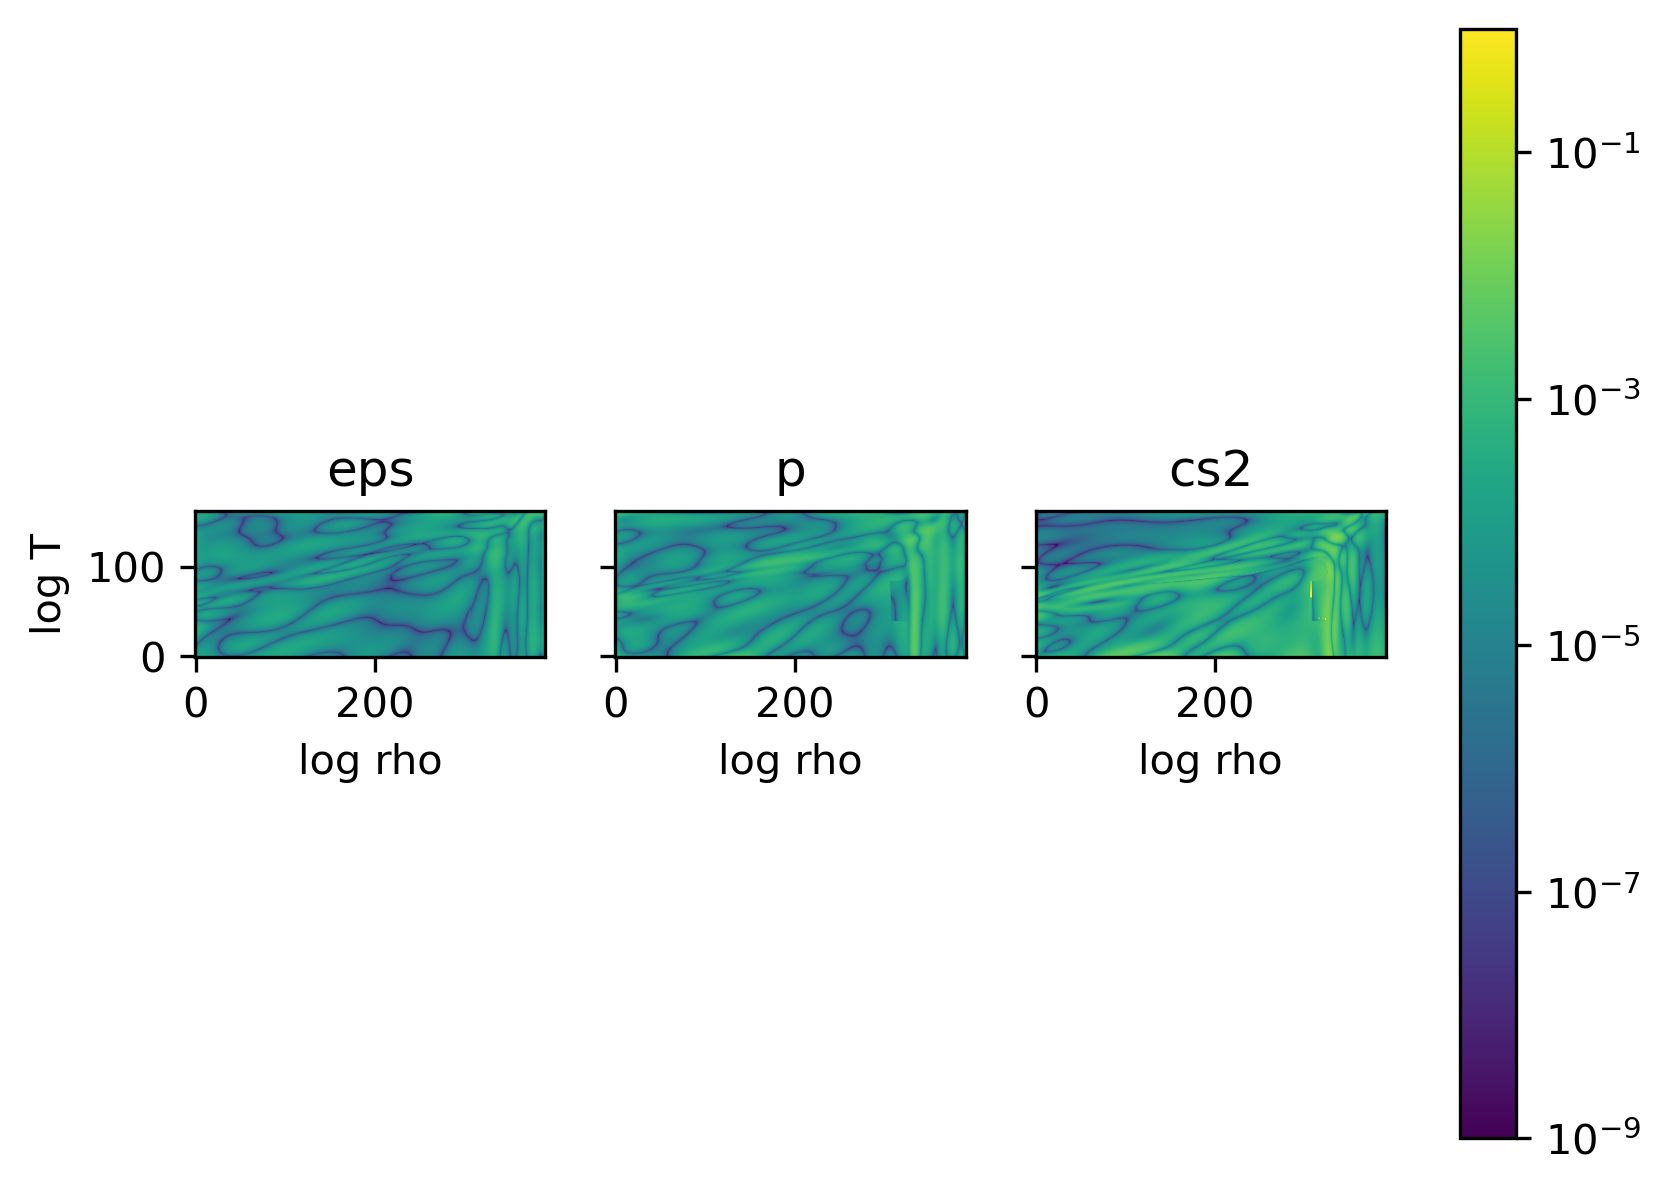

In [151]:
# Convert model to float
model = model.float()

# Target list
targets_list = [logenergy, logpress, np.log(cs2)]
titles_list = ["eps", "p", "cs2"]

# Initialize the plot
fig, axs = plt.subplots(1, len(targets_list), sharey=True)

# Choose the norm function to compare targets against predictions
norm_function = nnc2p.l2_norm

for i, ax in enumerate(axs):
    # Slice predictions
    sliced_predictions = predictions[:, i]
    values = targets_list[i]
    # Initialize v and zero the matrix
    targets = values[ye_index]
    targets = np.swapaxes(targets, 0, 1)
    # "Flatten" the array, but have to do it manually for some reason
    target_values = []
    for a in range(n_logtemp):
        for b in range(n_logrho):
            target_values.append(targets[b, a])
    target_values = np.array(target_values)
    delta_vals = norm_function(target_values, sliced_predictions, reduction=False)
    delta_vals = delta_vals.reshape((n_logtemp, n_logrho))
    # Then plot it
    im = ax.imshow(delta_vals, origin="lower", norm=LogNorm(vmin=1e-9, vmax=1e0))
    ax.set_xlabel("log rho")
    if i == 0:
        ax.set_ylabel("log T")
    ax.set_title(titles_list[i])
fig.colorbar(im, ax=axs)
plt.savefig(os.path.join(master_dir, "Plots/recovery_tabular_EOS.pdf"), bbox_inches='tight')
plt.show()

In [133]:
np.max(delta_vals)

0.09353939852511672

# Now, NNEOS with eps as input

__NNEOS__: try to replicate the EOS table (at least the core variables we are interested in) using the "input" variables logrho, logtemp, ye.

## Convert EOS table to table of training examples

In [28]:
# Get the filename of converted training data
filename = os.path.join(eos_tables_dir, "converted_eos_table.h5")

In [32]:
# Create new dataset (if desired)
# Specify output vars as "var_names" argument in this function - see physics.py
eos_table = physics.read_eos_table(os.path.join(eos_tables_dir, eos_table_filename))
physics.convert_eos_table(eos_table, save_name=filename)
eos_table.close()

In [44]:
# Load the dataset afterwards
train_eos_table = h5py.File(filename, 'r')
# Get the data saved in the HDF5 file
logrho    = train_eos_table["logrho"][:]
logtemp   = train_eos_table["logtemp"][:]
ye        = train_eos_table["ye"][:]
logenergy = train_eos_table["logenergy"][:]
logpress  = train_eos_table["logpress"][:]
cs2       = train_eos_table["cs2"][:]
# Close the file
train_eos_table.close()

## Preprocess the data

### Delete negative $c_s^2$ values

There are apparently a few negative values for the speed of sound... They are likely a bug in the code? We'll remove them.

In [45]:
negative_indices = np.argwhere(cs2 < 0)
negative_indices

array([[3629826],
       [3629892],
       [3629958],
       [3630024],
       [3630090],
       [3630156],
       [3630222],
       [3630288],
       [3630354]], dtype=int64)

In [46]:
logrho    = np.delete(logrho, negative_indices, axis=0)
logtemp   = np.delete(logtemp, negative_indices, axis=0)
ye        = np.delete(ye, negative_indices, axis=0)
logenergy = np.delete(logenergy, negative_indices, axis=0)
logpress  = np.delete(logpress, negative_indices, axis=0)
cs2       = np.delete(cs2, negative_indices, axis=0)

### Use log values for $c_s^2$

Use ln-log for the cs2 values

In [47]:
logcs2 = np.log(cs2)

### Convert to Torch `Datasets` for training the network

Get into features and labels arrays

In [72]:
features = np.transpose(np.array([logrho, logenergy, ye]))
labels   = np.transpose(np.array([logpress, logcs2]))

In [73]:
features

array([[3.02399601e+00, 1.92791052e+01, 5.00000000e-03],
       [3.02399601e+00, 1.92737118e+01, 1.50000000e-02],
       [3.02399601e+00, 1.92682506e+01, 2.50000000e-02],
       ...,
       [1.60239960e+01, 2.18308759e+01, 6.35000000e-01],
       [1.60239960e+01, 2.18329045e+01, 6.45000000e-01],
       [1.60239960e+01, 2.18350195e+01, 6.55000000e-01]])

In [74]:
labels

array([[17.99956976, 34.99350003],
       [17.98882544, 34.96926659],
       [17.97767427, 34.94419453],
       ...,
       [38.04153941, 48.64945001],
       [38.04353683, 48.65028179],
       [38.04565595, 48.65120679]])

Get the training data as DataSet and DataLoader objects. Note on normalization: we fit transform on the training data, then use the fitted scaler object to transform (i.e. using same transformation as the training data) the test set.

In [75]:
# For normalization, use sklearn's StandardScaler
scaler = StandardScaler()
# Do train test split here
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=42)
# "Cutoff": only use certain portion of the data for training and testing, to speed up training when tuning architecture 
cutoff = 0.025
print(len(train_features))
end = int(cutoff*len(train_features))
train_features = train_features[:end]
train_labels = train_labels[:end]
end = int(cutoff*len(test_features))
test_features = test_features[:end]
test_labels = test_labels[:end]
print(len(train_features))
# Convert to PyTorch Datasets as we defined them
train_dataset = data.HDF5Dataset(train_features, train_labels, normalization_function = scaler.fit_transform) 
test_dataset  = data.HDF5Dataset(test_features, test_labels, normalization_function = scaler.transform)
# Then create dataloaders, with batch size 32, from datasets
train_dataloader = DataLoader(train_dataset, batch_size = 32)
test_dataloader  = DataLoader(test_dataset, batch_size = 32)

3154776
78869


### Training and inference

Create a new instance of the Net:

In [76]:
model = Net(nb_of_inputs=3, nb_of_outputs=2, h=[50, 50], activation_function=torch.nn.ReLU).double()
# print(next(model.parameters()).is_cuda )

Or load from earlier:

In [77]:
# model = torch.load("../Models/tabeos_3_50_50_3.pt")
# test_input = [[1,1,1]]
# test_input = scaler.transform(test_input)
# test_input = torch.from_numpy(test_input).float()
# model(test_input)

In [78]:
print(scaler.mean_)
print(scaler.scale_)

[ 9.51608373 21.06592171  0.32936217]
[3.76043372 2.87800123 0.19028245]


In [79]:
# model.state_dict()["linear1.bias"]

In [80]:
nnc2p.count_parameters(model)

2850

Create a trainer object:

In [81]:
trainer = nnc2p.Trainer(model, 1e-1, train_dataloader=train_dataloader, test_dataloader=test_dataloader)

Train the network

In [82]:
trainer.train()

Training the model for 500 epochs.

 Epoch 0 
 --------------
Train loss: 4.90E-01
Test  loss: 4.78E-01

 Epoch 1 
 --------------
Train loss: 4.49E-01
Test  loss: 4.33E-01

 Epoch 2 
 --------------
Train loss: 3.82E-01
Test  loss: 3.70E-01

 Epoch 3 
 --------------
Train loss: 3.04E-01
Test  loss: 2.89E-01

 Epoch 4 
 --------------
Train loss: 2.96E-01
Test  loss: 2.83E-01

 Epoch 5 
 --------------
Train loss: 2.99E-01
Test  loss: 2.90E-01

 Epoch 6 
 --------------
Train loss: 4.13E-01
Test  loss: 3.95E-01

 Epoch 7 
 --------------
Train loss: 5.09E-01
Test  loss: 4.92E-01

 Epoch 8 
 --------------
Train loss: 5.19E-01
Test  loss: 5.01E-01

 Epoch 9 
 --------------
Train loss: 5.50E-01
Test  loss: 5.31E-01

 Epoch 10 
 --------------
Adapting learning rate to 0.05
Train loss: 4.66E-01
Test  loss: 4.48E-01

 Epoch 11 
 --------------
Train loss: 3.52E-01
Test  loss: 3.41E-01

 Epoch 12 
 --------------
Train loss: 3.53E-01
Test  loss: 3.42E-01

 Epoch 13 
 --------------
Train 

Train loss: 2.80E-01
Test  loss: 2.82E-01

 Epoch 113 
 --------------
Train loss: 2.80E-01
Test  loss: 2.82E-01

 Epoch 114 
 --------------
Train loss: 2.80E-01
Test  loss: 2.82E-01

 Epoch 115 
 --------------
Train loss: 2.80E-01
Test  loss: 2.82E-01

 Epoch 116 
 --------------
Adapting learning rate to 9.765625e-05
Train loss: 2.80E-01
Test  loss: 2.82E-01

 Epoch 117 
 --------------
Train loss: 2.80E-01
Test  loss: 2.82E-01

 Epoch 118 
 --------------
Train loss: 2.80E-01
Test  loss: 2.82E-01

 Epoch 119 
 --------------
Train loss: 2.80E-01
Test  loss: 2.82E-01

 Epoch 120 
 --------------
Train loss: 2.80E-01
Test  loss: 2.82E-01

 Epoch 121 
 --------------
Train loss: 2.80E-01
Test  loss: 2.82E-01

 Epoch 122 
 --------------
Train loss: 2.80E-01
Test  loss: 2.82E-01

 Epoch 123 
 --------------
Train loss: 2.80E-01
Test  loss: 2.82E-01

 Epoch 124 
 --------------
Train loss: 2.80E-01
Test  loss: 2.82E-01

 Epoch 125 
 --------------
Train loss: 2.80E-01
Test  loss: 2.82E

Train loss: 2.80E-01
Test  loss: 2.81E-01

 Epoch 223 
 --------------
Train loss: 2.80E-01
Test  loss: 2.81E-01

 Epoch 224 
 --------------
Train loss: 2.80E-01
Test  loss: 2.81E-01

 Epoch 225 
 --------------
Train loss: 2.80E-01
Test  loss: 2.81E-01

 Epoch 226 
 --------------
Adapting learning rate to 9.5367431640625e-08
Train loss: 2.80E-01
Test  loss: 2.81E-01

 Epoch 227 
 --------------
Train loss: 2.80E-01
Test  loss: 2.81E-01

 Epoch 228 
 --------------
Train loss: 2.80E-01
Test  loss: 2.81E-01

 Epoch 229 
 --------------
Train loss: 2.80E-01
Test  loss: 2.81E-01

 Epoch 230 
 --------------
Train loss: 2.80E-01
Test  loss: 2.81E-01

 Epoch 231 
 --------------
Train loss: 2.80E-01
Test  loss: 2.81E-01

 Epoch 232 
 --------------
Train loss: 2.80E-01
Test  loss: 2.81E-01

 Epoch 233 
 --------------
Train loss: 2.80E-01
Test  loss: 2.81E-01

 Epoch 234 
 --------------
Train loss: 2.80E-01
Test  loss: 2.81E-01

 Epoch 235 
 --------------
Train loss: 2.80E-01
Test  loss

Train loss: 2.80E-01
Test  loss: 2.81E-01

 Epoch 332 
 --------------
Train loss: 2.80E-01
Test  loss: 2.81E-01

 Epoch 333 
 --------------
Train loss: 2.80E-01
Test  loss: 2.81E-01

 Epoch 334 
 --------------
Train loss: 2.80E-01
Test  loss: 2.81E-01

 Epoch 335 
 --------------
Train loss: 2.80E-01
Test  loss: 2.81E-01

 Epoch 336 
 --------------
Adapting learning rate to 9.313225746154786e-11
Train loss: 2.80E-01
Test  loss: 2.81E-01

 Epoch 337 
 --------------
Train loss: 2.80E-01
Test  loss: 2.81E-01

 Epoch 338 
 --------------
Train loss: 2.80E-01
Test  loss: 2.81E-01

 Epoch 339 
 --------------
Train loss: 2.80E-01
Test  loss: 2.81E-01

 Epoch 340 
 --------------
Train loss: 2.80E-01
Test  loss: 2.81E-01

 Epoch 341 
 --------------
Train loss: 2.80E-01
Test  loss: 2.81E-01

 Epoch 342 
 --------------
Train loss: 2.80E-01
Test  loss: 2.81E-01

 Epoch 343 
 --------------
Train loss: 2.80E-01
Test  loss: 2.81E-01

 Epoch 344 
 --------------
Train loss: 2.80E-01
Test  lo

KeyboardInterrupt: 

Save architecture if desired

In [46]:
os.getcwd()

'D:\\Thibeau\\master-thesis-AI\\Code'

In [45]:
# torch.save(model, "../Models/taboes_3_50_50_3_relu.pt")

Report architecture (this saves info to a CSV, such as hidden layer set-up, nb of epochs trained, loss after training,... in order to compare performances across different architecture details).

In [31]:
# trainer.report_training("NNEOS_tab_experiments.csv", comment = "logeps, logpress and log cs2.")

Create a quick sketch of training

In [32]:
# plt.plot(trainer.train_losses, color='red', label="Train loss")
# plt.plot(trainer.test_losses, color='blue', label="Test loss")

# plt.grid()
# plt.legend()
# for ind in trainer.adaptation_indices:
#     plt.axvline(ind, ls = '--', color='grey')
# plt.yscale('log')
# plt.xlabel("Epochs")
# plt.ylabel("MSE Loss")
# plt.title("Training (50, 50) network tabular EOS for p and eps")
# plt.savefig("testing_training_tab_eos_network_50_50.pdf", bbox_inches = 'tight')
# plt.show()

### Load model after training

In case we have an already trained model, load it here. We have a network in `nn_tabeos_3_50_50_3.pth` (its state dict)

In [34]:
state_dict = torch.load("nn_tabeos_3_50_50_3.pth")
model.load_state_dict(state_dict)

<All keys matched successfully>

### Test the model

Get the errors on the different outputs, for different norms

In [61]:
with torch.no_grad():
    test_input = scaler.transform(train_features)
    test_input = torch.from_numpy(test_input)
    predictions = model(test_input)
    predictions = predictions.numpy()
    
l1     = nnc2p.l1_norm(predictions, train_labels)
l2     = nnc2p.l2_norm(predictions, train_labels)
linfty = nnc2p.linfty_norm(predictions, train_labels)

print(l1)
print(l2)
print(linfty)

[0.13238727 0.0453791  0.52563306 0.28614864]
[0.06588935 0.00316786 0.63449029 0.31325426]
[2.33104638 0.23211298 3.28741243 5.00458943]


We will analyze the performance of the code in its accuracy as a function of the different domains. We fix the $Y_e$ value, and look at the error rates (absolute values) on the three as a function of log T and log rho.

In [142]:
# Fix a ye value here, can severely affect the results?
ye_index = len(ye) // 2
ye_value = ye[ye_index]
# Get the ranges
n_logrho, n_logtemp = targets.shape

Prepare the values to determine the accuracy:

In [143]:
# Get the values at this ye index: these are the "targets"
targets = logenergy[ye_index]
targets = np.swapaxes(targets, 0, 1)

Get the input values right

In [144]:
input_values = []
for logtemp_value in logtemp:
    for logrho_value in logrho:
        new_row = [logrho_value, logtemp_value, ye_value]
        input_values.append(new_row)
input_values = np.array(input_values)

Scaler transform & to tensor

In [147]:
input_values = scaler.transform(input_values)
input_values = torch.from_numpy(input_values).float()

In [148]:
with torch.no_grad():
    predictions = model(input_values)
    predictions = predictions.numpy()

In [149]:
predictions

array([[19.290712, 18.032537, 35.008884],
       [19.291523, 18.063354, 35.008648],
       [19.292202, 18.09436 , 35.008568],
       ...,
       [21.827118, 37.9868  , 48.73516 ],
       [21.876057, 38.07058 , 48.745255],
       [21.923769, 38.151787, 48.754364]], dtype=float32)

## Load and export model 

If desired, save the model

In [125]:
# torch.save(model, "nn_tabeos_3_50_50_3.pt")

If desired, load the original architecture (`tabular_eos_14_04.pth` contains for h = 50, 100, 20). 

In [124]:
# model = Net(nb_of_inputs=3, nb_of_outputs=3, h=[50, 50]).float()
# # Load the state dict
# state_dict = torch.load("nn_tabeos_3_50_50_3.pth") 
# # Convert everything to floats rather than doubles
# for key in state_dict:
#     state_dict[key] = state_dict[key].float()
# model.load_state_dict(state_dict)

<All keys matched successfully>

## Compare performance against trilinear interpolation

We see (by running the cell below several times) that network is quite robust in generalization, althought the $\ell_\infty$ norm can sometimes suddenly get quite high, so further investigation into training on the full table is needed.

In [139]:
logcs2 = np.log(cs2)

C:\Users\Eline\AppData\Local\Temp\ipykernel_740\2540522382.py:1: RuntimeWarning: invalid value encountered in log
  logcs2 = np.log(cs2)


In [32]:
# Sample features and their labels
n_samples = 10000
sample_ind = np.random.choice(len(features), size=min(len(features), n_samples), replace=False)
sample_features = features[sample_ind]
sample_labels = labels[sample_ind]
# Get predictions
with torch.no_grad():
    # Don't forget to apply normalization!!! We fixed the random seed for reproducibility
    sample_features = scaler.transform(sample_features)
    predictions = model(torch.from_numpy(sample_features).float())
    predictions = predictions.numpy()
    
# print(sample_labels[0])
# print(predictions[0])
print("L2       difference on sample: ", nnc2p.l2_norm(sample_labels, predictions))
# print(nnc2p.l1_norm(sample_labels, predictions))
print("Linfty difference on sample: ",nnc2p.linfty_norm(sample_labels, predictions))

L2       difference on sample:  [5.79356866e-05 1.25226940e-04 9.12292286e-04]
Linfty difference on sample:  [0.05582873 0.09545796 1.05165028]


Don't forget normalization (note: we can export the normalization procedure later on by saving the mean and std).

In [141]:
print(f"Mean: {scaler.mean_}, std: {scaler.scale_}")

Mean: [ 9.51608373 -0.30081866  0.32936217], std: [3.76043372 1.56992791 0.19028245]


## Compare network with trilinear interpolation

We use scipy for the interpolation: see [this docs page](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interpn.html#scipy.interpolate.interpn)

In [142]:
from scipy.interpolate import interpn

In [143]:
def randomn(a, b):
    """Generate a random number in the range [a, b]"""
    
    return a + (b-a)*np.random.rand()

We define our own trilinear interpolation routine based on scipy:

In [144]:
def trilinear_interpolation(points, values_list, test_points):
    """
    Does a single prediction using trilinear interpolation.
    """
    # Make the predictions
    predictions = [interpn(points, values, test_points) for values in values_list]            
    # Return transpose: shape is (n_samples, n_vars) similar to neural network
    return np.transpose(np.array(predictions))

For the grid points, we reverse the order compared to the EOS table. That is, the EOS table uses (ye, logtemp, logrho), but we will use (logrho, logtemp, ye).

In [146]:
logpress_reversed = np.swapaxes(logpress, 0, 2)
logenergy_reversed = np.swapaxes(logenergy, 0, 2)
logcs2_reversed = np.swapaxes(logcs2, 0, 2)
print(logpress_reversed.shape)

(391, 163, 66)


In [147]:
def sample_eos(logrho, logtemp, ye, n_examples = 1):
    """
    Simple auxiliary function that returns a random input data point for an EOS table, based on its (logrho, logtemp, ye) values.
    """
    
    return np.stack([[randomn(min(logrho), max(logrho)), randomn(min(logtemp), max(logtemp)), randomn(min(ye), max(ye))] for _ in range(n_examples)])

In [172]:
# Get an array of test cases:
n_examples = 10000
test_points = sample_eos(logrho, logtemp, ye, n_examples=n_examples)
# Grid of tables
points = (logrho, logtemp, ye)
# Variables we wish to get
values_list = [logenergy_reversed, logpress_reversed, logcs2_reversed]
# Interpolation
interpolated = trilinear_interpolation(points, values_list, test_points)
# print(interpolated)  # print in case n_examples is low
# Compare with neural net
with torch.no_grad():
    # Don't forget normalization!!!
    test_points_n = scaler.transform(test_points)
    predictions = model(torch.from_numpy(test_points_n).float())
    predictions = predictions.numpy()
#     print(predictions)  # print in case n_examples is low

Now get error rates

In [174]:
l1_error, l2_error, linfty_error = nnc2p.l1_norm(interpolated, predictions), nnc2p.l2_norm(interpolated, predictions), nnc2p.linfty_norm(interpolated, predictions)

In [175]:
print(l1_error)
print(l2_error)
print(linfty_error)

[0.00565407 0.0081235  0.01305064]
[5.65448465e-05 1.19128211e-04 7.66002332e-04]
[0.05040054 0.08126448 0.99801589]


## Compare performance of methods

Here, we will try to compare the performance of the methods, by measuring the time they take (CPU time) through `timeit`.

In [176]:
# Get a single point that has to be predicted
test_point = sample_eos(logrho, logtemp, ye)

Choose the number of runs and number of loops within each run

In [177]:
n_runs = 10
n_loops = 10000

In [178]:
def time_execution(func, n_runs=10, n_loops=10000, verbose=True):
    # Save all the runtimes
    runtimes = []
    for _ in range(n_runs):
        # Start timer each run
        start = time.process_time_ns()
        for _ in range(n_loops):
            func()
        end = time.process_time_ns()
        # Convert to micro seconds and get average for one loop
        time_run = (end-start)/1000
        time_loop = time_run/n_loops
        runtimes.append(time_loop)
    
    # Convert to mean adn std
    mu, sigma = np.mean(runtimes), np.std(runtimes)
    
    if verbose:
        print(f"{mu} \pm {sigma} per loop ({n_runs} runs, {n_loops} each)")
    
    return mu, sigma

### Trilinear interpolation

Performance of trilinear interpolation with Scipy:

In [179]:
# Which values to predict?
values_list = [logenergy_reversed, logpress_reversed]
# single value:
val = logenergy_reversed
def function1():
    [interpn(points, val, test_point) for val in values_list]

In [180]:
# %timeit -r10 -n10000 interpn(points, logenergy_reversed, test_point)  # measure Scipy

### Neural network (using PyTorch)

Performance of running the network with PyTorch built-ins: first convert point to right format

In [181]:
test_point_n = scaler.transform(test_point)
test_point_torch = torch.from_numpy(test_point_n).float()

In [182]:
def function2():
    model(test_point_torch)

### Neural network (using PyTorch, no grad)

It might be that saving the gradients etc in PyTorch can slow down the inference: check performance with grads disabled

In [183]:
def function3():
    with torch.no_grad():
        model(test_point_torch)

### Neural network (using ONNX Runtime)

In [184]:
def function4():
    ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
    ort_outs = ort_session.run(None, ort_inputs)

### Neural network (using Numpy)

Other comparison: the neural network but just the matrices and using Numpy! Save everything externally

In [185]:
w1 = model.state_dict()["linear1.weight"].numpy()
b1 = model.state_dict()["linear1.bias"].numpy()
w2 = model.state_dict()["linear2.weight"].numpy()
b2 = model.state_dict()["linear2.bias"].numpy()
w3 = model.state_dict()["linear3.weight"].numpy()

In [186]:
test_point_np = test_point_n[0]

In [187]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [188]:
def run_nn(x):
    x = np.matmul(w1, x) + b1
    x = sigmoid(x)
    x = np.matmul(w2, x) + b2
    x = sigmoid(x)
    x = np.matmul(w3, x)
    
    return x

In [189]:
# Check if we get the same results -- OK
print(test_point)
test1 = run_nn(test_point[0])
print(test1)
with torch.no_grad():
    test2 = model(torch.from_numpy(test_point[0]).float())
    test2 = test2.numpy()
print(test2)

[[11.57061122 -0.15633412  0.08561414]]
[21.82010524 38.72651337 47.77346631]
[21.820105 38.726513 47.773468]


In [190]:
def function5():
    run_nn(test_point_np)

### Python (no packages)

Convert everything to lists

In [191]:
test_point_list = test_point_np.tolist()
test_point_list = [[val] for val in test_point_list]
print(test_point_list)
w1_list = w1.tolist()
# b1_list = b1.tolist()
b1_list = [[b1[i]] for i in range(len(b1))]
# b1_list = [b1_list]
w2_list = w2.tolist()
b2_list = [[b2[i]] for i in range(len(b2))]
w3_list = w3.tolist()

[[0.5463538641652405], [0.09203259199418481], [-1.280980106027008]]


Get sigmoid function without numpy

In [192]:
def sigmoid_list(x):
    return [[1/(1+2.71828182845904523536028747135266249**(-x[i][0]))] for i in range(len(x))]

In [193]:
def mm(A, B):
    """Matrix multiplication, pure Python"""
    return [[sum(a*b for a,b in zip(A_row, B_col)) for B_col in zip(*B)] for A_row in A]

In [194]:
a = [[2, 0, 0], [0, 2, 0], [0, 0, 2]]
b = [[1],[2],[3]]
first = mm(a,b)
print(first)
second = sigmoid_list(b)
[[first[i][0] + second[i][0]] for i in range(len(first))]

[[2], [4], [6]]


[[2.731058578630005], [4.880797077977882], [6.952574126822433]]

In [195]:
def run_nn_list(x):
    x = mm(w1_list, x)
    x = [[x[i][0] + b1_list[i][0]] for i in range(len(x))]
    x = sigmoid_list(x)
    x = mm(w2_list, x)
    x = [[x[i][0] + b2_list[i][0]] for i in range(len(x))]
    x = sigmoid_list(x)
    x = mm(w3_list, x)
    
    return x

The shape is slightly different, but this is good enough!

In [196]:
# Check if we get the same results -- OK
test1 = run_nn_list(test_point_list)
print(test1)
with torch.no_grad():
    test2 = model(test_point_torch)
    test2 = test2.numpy()
print(test2)

[[19.28380190064578], [29.502848125783046], [41.66890742358023]]
[[19.283802 29.50285  41.668907]]


In [197]:
def function6():
    run_nn_list(test_point_list)

__Do the runtime analysis__

In [198]:
# Empty lists
mu_list, sigma_list = [], []
# Functions & names for runtime analysis
funcs = [function1, function2, function3, function5]
method_names = ["Interpolation", "PyTorch", "PyTorch (no grad)", "Numpy"]  # , "Pure Python"
for i, func in enumerate(funcs):
    print(f"--- {method_names[i]} ---")
    mu, sigma = time_execution(func)
    mu_list.append(mu)
    sigma_list.append(sigma)

--- Interpolation ---
513.125 \pm 5.284854539152426 per loop (10 runs, 10000 each)
--- PyTorch ---
101.40625 \pm 0.8414320011147662 per loop (10 runs, 10000 each)
--- PyTorch (no grad) ---
73.125 \pm 0.625 per loop (10 runs, 10000 each)
--- Numpy ---
20.15625 \pm 1.09375 per loop (10 runs, 10000 each)


In [213]:
speedup = round(mu_list[0]/mu_list[-1])
print(f"Best neural net implementation is around {speedup}x faster.")

Best neural net implementation is around 25x faster.



### Plot to combine analysis

Prepare the plot, sort values etc

In [208]:
xticks = [i+1 for i in range(len(method_names))]
yvals = mu_list
yerrs = sigma_list

In [209]:
# cutoff = 5

# # Get vals more clearly, do cutoff
# xvals = xticks[:cutoff]
# yvals = mu_list[:cutoff]
# yerrs = sigma_list[:cutoff]
# # Swap based on performance  ## NOT WORKING FOR SOME REASON
# # sort_ind = np.argsort(yvals)[::-1]
# # # Sort
# # xvals = my_sort(xvals, sort_ind)
# # yvals = my_sort(yvals, sort_ind)
# # yerrs = my_sort(yerrs, sort_ind)
# # method_names = my_sort(method_names, sort_ind)

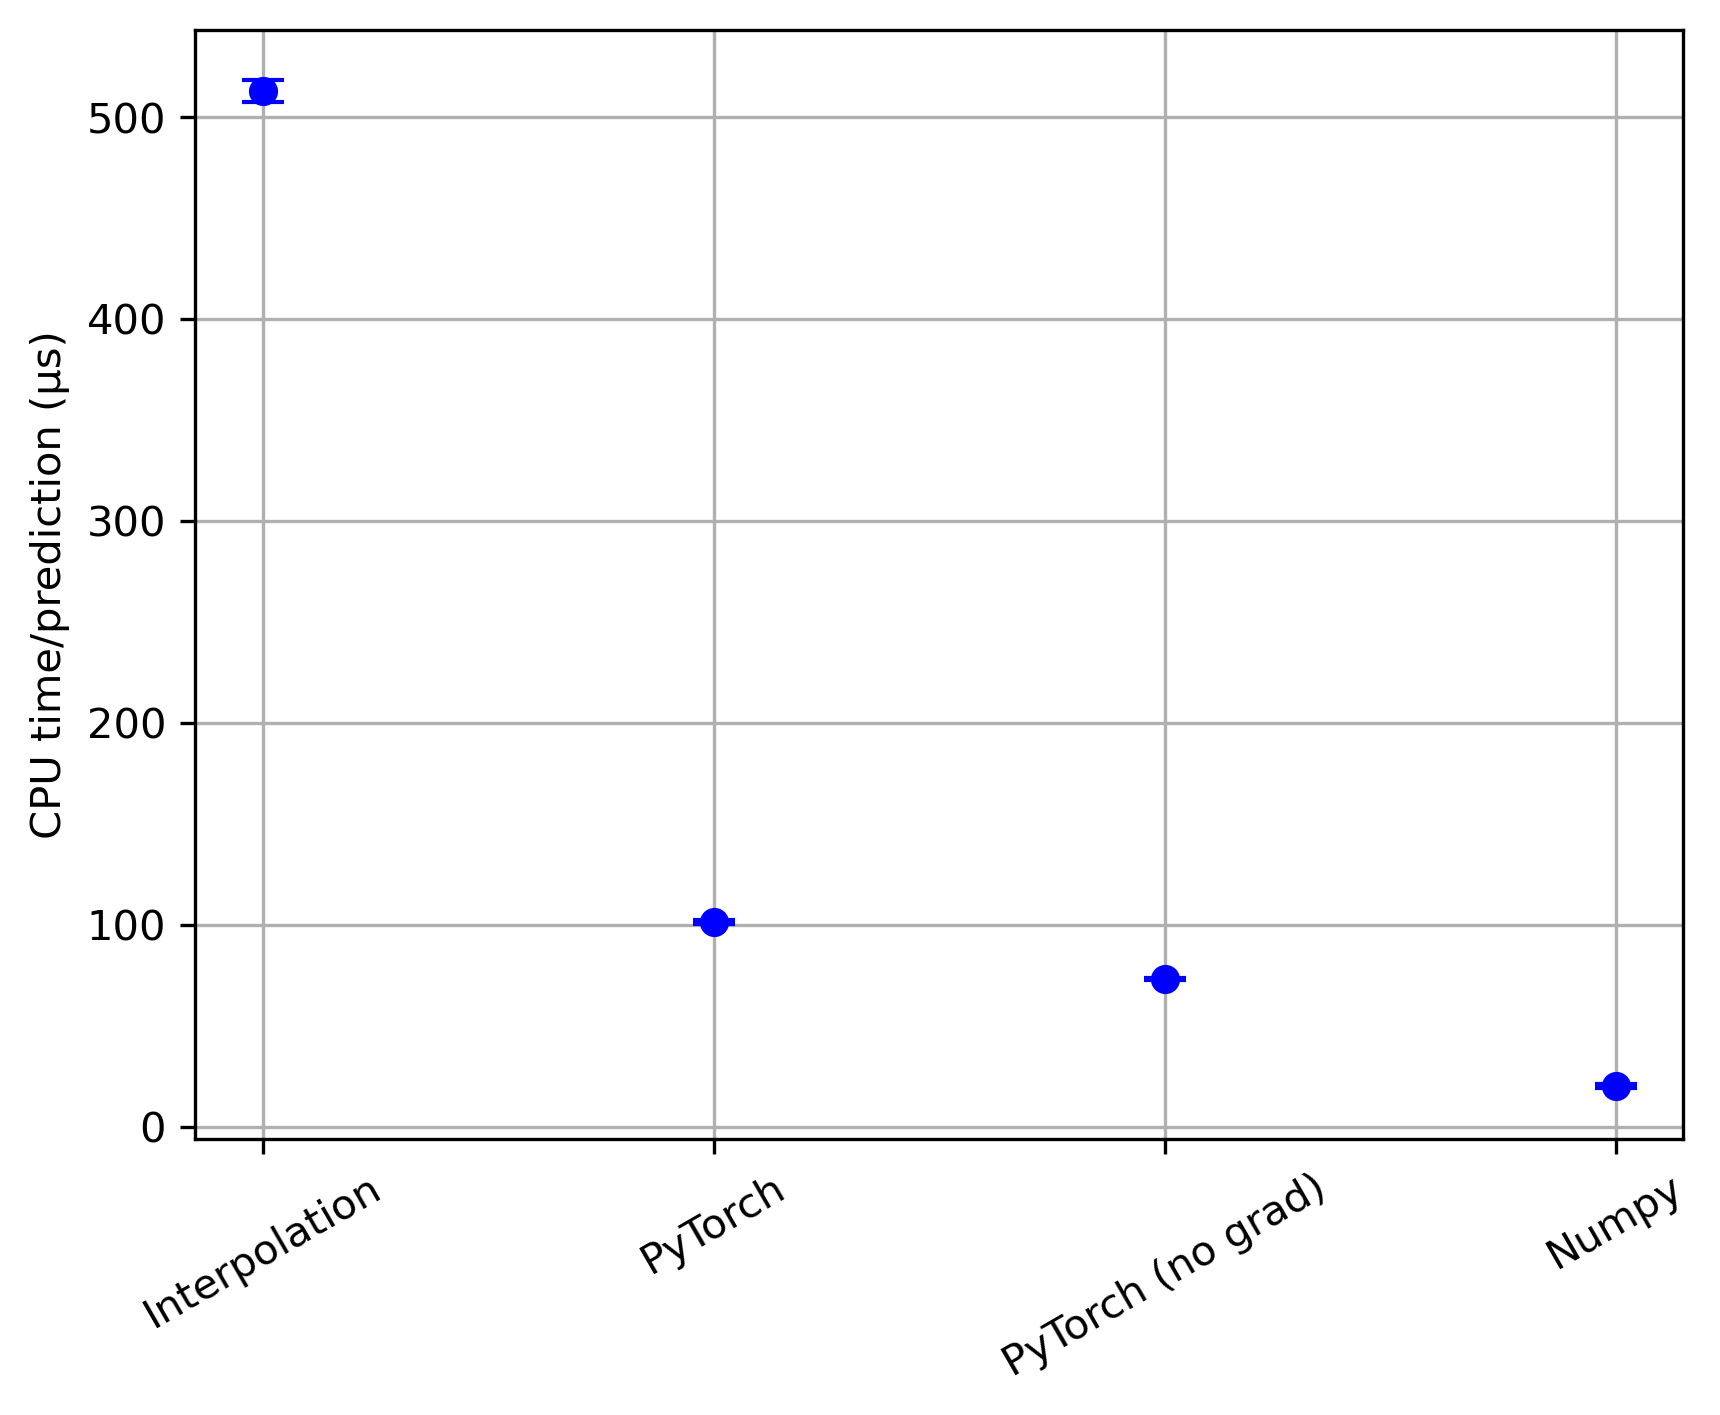

In [210]:
# Preparation
plt.errorbar(xticks, yvals, yerrs, fmt="o", color="blue", capsize=5)
plt.xticks(ticks=xticks, labels = method_names, rotation=30)
plt.ylabel("CPU time/prediction (µs)")
plt.grid()
plt.savefig("Time comparison single prediction")
# plt.savefig("interpolation_neuralnet_speed_comparison.pdf", bbox_inches='tight')
plt.show()

# Second goal: NNC2P

__TO DO__ think about design of architecture AND fix the conserved variable values -- I think they were not computed correctly before! 

__NNC2P__: try to replicate the full C2P conversion.

Generate training data through sampling and looking-up in the table. Save/load from our eos tables dir, where all (too large) datasets related to the EOS tables are saved to.

In [83]:
print(eos_tables_dir)

D:/Coding/Datasets/eos_tables


Construct datasets if desired

In [90]:
# # Open EOS table
# eos_table = physics.read_eos_table(os.path.join(eos_tables_dir, eos_table_filename))
# physics.generate_c2p_data_tabular_eos(eos_table, number_of_points=100000, save_name=os.path.join(eos_tables_dir, "train_c2p_data.h5"))
# eos_table.close()

Load in the dataset afterwards

In [91]:
# Load the dataset afterwards
train_c2p_table = h5py.File(os.path.join(eos_tables_dir, "train_c2p_data.h5"), 'r')
# Get the data saved in the HDF5 file for training
# NOTE have to convert to float not double, otherwise PyTorch gives an error
features = train_c2p_table["features"][:].astype(np.float32)
labels = train_c2p_table["labels"][:].astype(np.float32)
# # See what's in there
# for key in train_c2p_table:
#     print(key)

# Close the file
train_c2p_table.close()

Explore this dataset

In [92]:
print("Min of input")
print(np.min(features, axis=0))
print("Max of input")
print(np.max(features, axis=0))
print("---")
print("Min of output")
print(np.min(labels, axis=0))
print("Max of output")
print(np.max(labels, axis=0))

Min of input
[3.0239964e+00 1.9037802e+01 2.2053352e+01 4.9999999e-03]
Max of input
[16.18306  38.488518 38.472675  0.655   ]
---
Min of output
[17.457466]
Max of output
[38.162045]


### Convert to Torch `Datasets` for training the network

Get the training data as DataSet and DataLoader objects. Note on normalization: we fit transform on the training data, then use the fitted scaler object to transform (i.e. using same transformation as the training data) the test set.

In [95]:
# For normalization, use sklearn's StandardScaler
scaler = StandardScaler()
# Do train test split here
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=42)
# "Cutoff": only use certain portion of the data for training and testing, to speed up training when tuning architecture 
# Note - our sampling procedure above guarantees we can ignore the cutoff, unlike the NNEOS code above which had 4 million datapoints in total
cutoff = 1
print(f"Size training data: {len(train_features)}")
print(f"Size testing data: {len(test_features)}")
end = int(cutoff*len(train_features))
train_features = train_features[:end]
train_labels = train_labels[:end]
end = int(cutoff*len(test_features))
test_features = test_features[:end]
test_labels = test_labels[:end]
print(f"Size training data (cutoff): {len(train_features)}")
# Convert to PyTorch Datasets as we defined them
train_dataset = data.HDF5Dataset(train_features, train_labels, normalization_function = scaler.fit_transform) 
test_dataset  = data.HDF5Dataset(test_features, test_labels, normalization_function = scaler.transform)
# Then create dataloaders, with batch size 32, from datasets
train_dataloader = DataLoader(train_dataset, batch_size = 32)
test_dataloader  = DataLoader(test_dataset, batch_size = 32)

Size training data: 75000
Size testing data: 25000
Size training data (cutoff): 75000


Get the scaler's attributes: 

In [96]:
print(f"Scaler mean: {scaler.mean_}, \n Scaler std: {scaler.scale_}")

Scaler mean: [ 9.58863041 30.23533938 30.7298278   0.3288648 ], 
 Scaler std: [3.76007097 4.0125932  3.91964587 0.1902224 ]


### Archive

Create a new instance of the Net:

In [105]:
model = Net(nb_of_inputs = 4, nb_of_outputs = 1, h=[600, 200], activation_function=torch.nn.ReLU)
model = model.float()

In [106]:
nnc2p.count_parameters(model)

123400

Create a trainer object from it:

In [110]:
trainer = nnc2p.Trainer(model, 1e-3, train_dataloader=train_dataloader, test_dataloader=test_dataloader)

In [ ]:
trainer.train()

Training the model for 500 epochs.

 Epoch 0 
 --------------
Train loss: 5.70E-02
Test  loss: 5.92E-02

 Epoch 1 
 --------------
Train loss: 5.69E-02
Test  loss: 5.90E-02

 Epoch 2 
 --------------
Train loss: 5.66E-02
Test  loss: 5.87E-02

 Epoch 3 
 --------------
Train loss: 5.64E-02
Test  loss: 5.85E-02

 Epoch 4 
 --------------
Train loss: 5.63E-02
Test  loss: 5.84E-02

 Epoch 5 
 --------------
Train loss: 5.63E-02
Test  loss: 5.83E-02

 Epoch 6 
 --------------
Train loss: 5.61E-02
Test  loss: 5.81E-02

 Epoch 7 
 --------------
Train loss: 5.59E-02
Test  loss: 5.80E-02

 Epoch 8 
 --------------
Train loss: 5.57E-02
Test  loss: 5.78E-02

 Epoch 9 
 --------------
Train loss: 5.57E-02
Test  loss: 5.78E-02

 Epoch 10 
 --------------
Train loss: 5.53E-02
Test  loss: 5.74E-02

 Epoch 11 
 --------------
Train loss: 5.54E-02
Test  loss: 5.75E-02

 Epoch 12 
 --------------
Train loss: 5.52E-02
Test  loss: 5.73E-02

 Epoch 13 
 --------------
Train loss: 5.51E-02
Test  loss: 5.71

Train loss: 4.85E-02
Test  loss: 5.05E-02

 Epoch 117 
 --------------
Train loss: 4.85E-02
Test  loss: 5.05E-02

 Epoch 118 
 --------------
Train loss: 4.84E-02
Test  loss: 5.05E-02

 Epoch 119 
 --------------
Train loss: 4.84E-02
Test  loss: 5.05E-02

 Epoch 120 
 --------------
Train loss: 4.84E-02
Test  loss: 5.05E-02

 Epoch 121 
 --------------
Train loss: 4.84E-02
Test  loss: 5.05E-02

 Epoch 122 
 --------------
Train loss: 4.84E-02
Test  loss: 5.04E-02

 Epoch 123 
 --------------
Train loss: 4.84E-02
Test  loss: 5.05E-02

 Epoch 124 
 --------------
Train loss: 4.84E-02
Test  loss: 5.04E-02

 Epoch 125 
 --------------
Train loss: 4.84E-02
Test  loss: 5.04E-02

 Epoch 126 
 --------------
Train loss: 4.84E-02
Test  loss: 5.04E-02

 Epoch 127 
 --------------
Train loss: 4.83E-02
Test  loss: 5.04E-02

 Epoch 128 
 --------------
Train loss: 4.83E-02
Test  loss: 5.04E-02

 Epoch 129 
 --------------
Train loss: 4.83E-02
Test  loss: 5.04E-02

 Epoch 130 
 --------------
Train 

Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 229 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 230 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 231 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 232 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 233 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 234 
 --------------
Adapting learning rate to 9.765625e-07
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 235 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 236 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 237 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 238 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 239 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 240 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 241 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E

Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 339 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 340 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 341 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 342 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 343 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 344 
 --------------
Adapting learning rate to 9.5367431640625e-10
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 345 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 346 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 347 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 348 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 349 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 350 
 --------------
Train loss: 4.72E-02
Test  loss: 4.93E-02

 Epoch 351 
 --------------
Train loss: 4.72E-02
Test  loss

Create a quick sketch of training

In [ ]:
# plt.plot(trainer.train_losses, color='red', label="Train loss")
# plt.plot(trainer.test_losses, color='blue', label="Test loss")

# plt.grid()
# plt.legend()
# for ind in trainer.adaptation_indices:
#     plt.axvline(ind, ls = '--', color='grey')
# plt.yscale('log')
# plt.xlabel("Epochs")
# plt.xlabel("MSE Loss")
# plt.title("Training (100, 100) network tabular EOS for p and eps")
# plt.savefig("testing_training_tab_eos_network_100_100.pdf", bbox_inches = 'tight')
# plt.show()

# Archive: NNE2T

__NNE2T__: try to replicate the conversion from energy to temperature, which is currently done by rootfinding approximations & lookups in the EOS table (see Gmunu code). It seemed harder than I initially thought to model and train this; and in the end, I'm not sure how useful it'll be, so I'm archiving this.

Get the training data as DataSet and DataLoader objects. Note on normalization: we fit transform on the training data, then use the fitted scaler object to transform (i.e. using same transformation as the training data) the test set.

In [ ]:
# Give the names of the input vars (features) and output vars (labels)
in_vars = ["rho", "eps", "ye"]
out_vars = ["temp"]
# For normalization, use sklearn's StandardScaler
scaler = StandardScaler()
# Read the sampled data as pandas dataframes
train_df = pd.read_csv(os.path.join(master_dir, "Data/SLy4_training_data.csv"))
test_df  = pd.read_csv(os.path.join(master_dir, "Data/SLy4_test_data.csv"))
# Convert to PyTorch Datasets as we defined them
train_dataset = data.CustomDataset(train_df, feature_names = in_vars, label_names = out_vars, normalization_function = scaler.fit_transform) 
test_dataset  = data.CustomDataset(test_df, feature_names = in_vars, label_names = out_vars, normalization_function = scaler.transform)
# Then create dataloaders, with batch size 32, from datasets
train_dataloader = DataLoader(train_dataset, batch_size=32)
test_dataloader  = DataLoader(test_dataset, batch_size=32)

Create a new instance of the Net:

In [ ]:
model = Net(nb_of_inputs = 3, nb_of_outputs = 1, h=[50, 50])
model

Net(
  (linear1): Linear(in_features=3, out_features=50, bias=True)
  (activation1): Sigmoid()
  (linear2): Linear(in_features=50, out_features=50, bias=True)
  (activation2): Sigmoid()
  (linear3): Linear(in_features=50, out_features=1, bias=False)
)

In [ ]:
nnc2p.count_parameters(model)

2800

Create a trainer object from it:

In [ ]:
trainer = nnc2p.Trainer(model, 1e-1, train_dataloader=train_dataloader, test_dataloader=test_dataloader)

In [ ]:
trainer.train()

Training the model for 500 epochs.

 Epoch 0 
 --------------
Train loss: 7.59E-01
Test  loss: 7.62E-01

 Epoch 1 
 --------------
Train loss: 9.92E-01
Test  loss: 9.98E-01

 Epoch 2 
 --------------
Train loss: 9.45E-01
Test  loss: 9.61E-01

 Epoch 3 
 --------------
Train loss: 8.24E-01
Test  loss: 8.29E-01

 Epoch 4 
 --------------
Train loss: 9.10E-01
Test  loss: 9.16E-01

 Epoch 5 
 --------------
Train loss: 8.80E-01
Test  loss: 8.91E-01

 Epoch 6 
 --------------
Train loss: 8.62E-01
Test  loss: 8.67E-01

 Epoch 7 
 --------------
Train loss: 8.20E-01
Test  loss: 8.27E-01

 Epoch 8 
 --------------
Train loss: 8.80E-01
Test  loss: 8.94E-01

 Epoch 9 
 --------------
Train loss: 9.20E-01
Test  loss: 9.26E-01

 Epoch 10 
 --------------
Train loss: 7.34E-01
Test  loss: 7.39E-01

 Epoch 11 
 --------------
Train loss: 7.48E-01
Test  loss: 7.56E-01

 Epoch 12 
 --------------
Train loss: 7.28E-01
Test  loss: 7.31E-01

 Epoch 13 
 --------------
Train loss: 8.87E-01
Test  loss: 8.99

KeyboardInterrupt: 

Create a quick sketch of training

In [ ]:
# plt.plot(trainer.train_losses, color='red', label="Train loss")
# plt.plot(trainer.test_losses, color='blue', label="Test loss")

# plt.grid()
# plt.legend()
# for ind in trainer.adaptation_indices:
#     plt.axvline(ind, ls = '--', color='grey')
# plt.yscale('log')
# plt.xlabel("Epochs")
# plt.xlabel("MSE Loss")
# plt.title("Training (100, 100) network tabular EOS for p and eps")
# plt.savefig("testing_training_tab_eos_network_100_100.pdf", bbox_inches = 'tight')
# plt.show()

# Archive (safely ignore)

If desired, creat jit and onnx of the model

In [78]:
# x = scaler.transform(features[1000].reshape(1,-1))
# x = torch.from_numpy(x).float()
# print("Example")
# print(x[0][0].item())
# print(x[0][1].item())
# print(x[0][2].item())
# torch_out = model(x)
# print("Output")
# print(torch_out[0][0].item())
# print(torch_out[0][1].item())

Example
-1.728142261505127
-1.4035654067993164
-1.1849615573883057
Output
19.214147567749023
18.384708404541016


In [79]:
# ## ONNX
# # Export the model
# torch.onnx.export(model,               # model being run
#                   x,                         # model input (or a tuple for multiple inputs)
#                   "tab_eos.onnx",   # where to save the model (can be a file or file-like object)
#                   export_params=True,        # store the trained parameter weights inside the model file
#                   opset_version=10,          # the ONNX version to export the model to
#                   do_constant_folding=True,  # whether to execute constant folding for optimization
#                   input_names = ['input'],   # the model's input names
#                   output_names = ['output'], # the model's output names
#                   dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
#                                 'output' : {0 : 'batch_size'}})
# ## Torchscript
# # Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
# traced_script_module = torch.jit.trace(model, x)

# # Save the TorchScript model
# traced_script_module.save("tab_eos.pt")

Testing ONNX here!!! See [this PyTorch docs page for info.](https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html)

In [111]:
# onnx_model = onnx.load("tab_eos.onnx")
# onnx.checker.check_model(onnx_model)

In [112]:
# ort_session = onnxruntime.InferenceSession("tab_eos.onnx")

# def to_numpy(tensor):
#     return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# # compute ONNX Runtime output prediction
# ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
# ort_outs = ort_session.run(None, ort_inputs)

# # compare ONNX Runtime and PyTorch results
# np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

# print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!
